In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from biom import load_table
from scipy.stats import ttest_rel, wilcoxon, ttest_ind, pearsonr, spearmanr
from skbio.stats.composition import multiplicative_replacement
import matplotlib.gridspec as gridspec
%matplotlib inline

Here, we will be reproducing the results from the atopic dermatis study from Byrd et al.
Then we will be performing a log-ratio analysis, and look at the ranks computed from the
multinomial regression.

In [2]:
beta = pd.read_csv('../results/byrd-results/beta.csv', index_col=0) # multinomial ranks
table = load_table('../data/byrd_skin_table.biom').to_dataframe().to_dense().T
metadata = pd.read_table('../data/byrd_metadata.txt', index_col=0)

sample_exclude = set(['MET0852', 'MET1504'])
metadata = metadata.loc[set(metadata.index) - sample_exclude]

In [3]:
def lesion_f(x):
    if x == 'F':
        return 'L'
    if x == 'NL':
        return 'NL'
    else:
        return x
metadata['Site'] = metadata['Timepoint'].apply(lesion_f)

In [4]:
metadata.Site.value_counts()

L     20
PF    20
B     10
Name: Site, dtype: int64

In [5]:
table = table.loc[:, table.sum(axis=0)>0]
table = table.apply(lambda x: x / x.sum(), axis=1)

In [6]:
def paired_test_statistic(f, category, md, df):
    cats = list(md[category].value_counts().index)
    src = md[md[category] == cats[0]].index
    dest = md[md[category] == cats[1]].index
    return f(df.loc[src].values, df.loc[dest].values)[0]

def paired_test_pvalue(f, category, md, df):
    cats = list(md[category].value_counts().index)
    src = md[md[category] == cats[0]].index
    dest = md[md[category] == cats[1]].index
    return f(df.loc[src].values, df.loc[dest].values)[1]

def correlation_test_statistic(f, category, md, df):
    return f(df.loc[md.index].values, md[category].values)[0]    

def correlation_test_pvalue(f, category, md, df):
    return f(df.loc[md.index].values, md[category].values)[1]

In [7]:
select_microbes = np.array(
    list(map(lambda x: x.rstrip(), 
             open('../data/byrd_final_microbes.txt', 'r').readlines())))

In [8]:
f = lambda x: paired_test_statistic(ttest_rel, category='Timepoint', md=metadata, df=x)
tstats = table.apply(f, axis=0)

f = lambda x: paired_test_pvalue(ttest_rel, category='Timepoint', md=metadata, df=x)
tpvals = table.apply(f, axis=0)

f = lambda x: correlation_test_statistic(pearsonr, category='Objective SCORAD', md=metadata, df=x)
rstats = table.apply(f, axis=0)

f = lambda x: correlation_test_pvalue(pearsonr, category='Objective SCORAD', md=metadata, df=x)
rpvals = table.apply(f, axis=0)

/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [9]:
stats = pd.DataFrame(
    {
        'tstats': tstats,
        'tpvals': tpvals,
        'rstats': rstats,
        'rpvals': rpvals,
        'multinomial_ranks': beta["C(Timepoint, Treatment('F'))[T.PF]"]
    }
) 
stats.to_csv('../figures/Table_S2.csv')

In [10]:
table = table[select_microbes]
genera = np.array(list(map(lambda x: x.split(';')[-2], select_microbes)))

In [11]:
tstats = table.apply(f, axis=0)
tpvals = table.apply(f, axis=0)
rstats = table.apply(f, axis=0)
rpvals = table.apply(f, axis=0)

In [12]:
select_stats = pd.DataFrame(
    {
        'tstats': tstats,
        'tpvals': tpvals,
        'rstats': rstats,
        'rpvals': rpvals
    }
) 
select_stats.to_csv('selected-byrd-univariate-stats.csv')

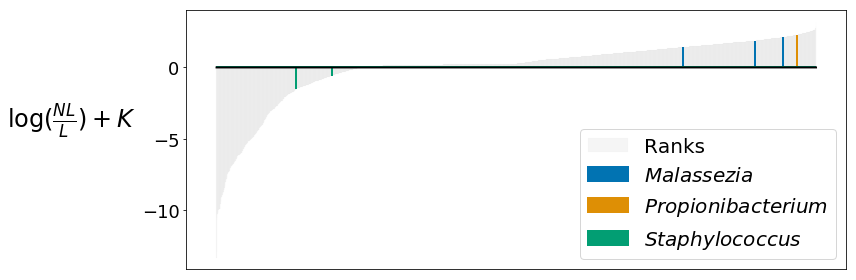

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))

# plot all of the ranks
coefs = beta["C(Timepoint, Treatment('F'))[T.PF]"].sort_values()
x = np.arange(coefs.shape[0])

ax.bar(x, coefs, 1, label='Ranks', alpha=0.2, edgecolor='#D0D0D0', lw=0.1, color='#D0D0D0') #gray
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel(r'$\log (\frac{NL}{L})+K$', fontsize=24, labelpad=70, rotation=0)
ax.yaxis.set_tick_params(labelsize=18)

genus_colors = dict(zip(np.unique(genera), sns.color_palette("colorblind", len(np.unique(genera)))))

for genus in np.unique(genera):

    filtered_beta = pd.Series(index=coefs.index).fillna(0)
    select_genus = select_microbes[genera == genus]
    filtered_beta[select_genus] = coefs[select_genus]

    ax.bar(x, filtered_beta.values, 1, label="$\it{%s}$" % genus, 
           alpha=1, edgecolor=genus_colors[genus], 
           facecolor=genus_colors[genus], lw=2)
    
ax.plot(x, np.array([0]*len(x)), c='k', lw=2)
ax.legend(fontsize=20)
plt.tight_layout()
fig.savefig('../figures/figure3/byrd-post-flare-ranks.png')

In [14]:
stats.head()

,multinomial_ranks,rpvals,rstats,tpvals,tstats
Archaea;Crenarchaeota;Thermoprotei;Desulfurococcales;Desulfurococcaceae;Aeropyrum;Aeropyrum_pernix,1.230925,0.390003,-0.124238,0.441617,-0.785901
Archaea;Crenarchaeota;Thermoprotei;Desulfurococcales;Desulfurococcaceae;Desulfurococcus;Desulfurococcus_kamchatkensis,0.225586,0.838426,-0.029579,0.329877,-1.000000
Archaea;Crenarchaeota;Thermoprotei;Desulfurococcales;Desulfurococcaceae;Ignicoccus;Ignicoccus_hospitalis,0.223589,0.304232,-0.148241,0.329877,-1.000000
Archaea;Crenarchaeota;Thermoprotei;Desulfurococcales;Desulfurococcaceae;Staphylothermus;Staphylothermus_marinus,0.248062,1.000000,NaN,NaN,NaN
Archaea;Crenarchaeota;Thermoprotei;Desulfurococcales;Pyrodictiaceae;Hyperthermus;Hyperthermus_butylicus,0.163231,1.000000,NaN,NaN,NaN


staphylococcus epidermis, 
staphylococcus aureus,
malasseziaceae globosa 

vs

propionibacterium

In [15]:
select_microbes

array(['Bacteria;Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;Staphylococcus_aureus',
       'Bacteria;Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;Staphylococcus_epidermidis',
       'Eukaryota;Fungi;Basidiomycota;Exobasidiomycetes;Malasseziales;Malasseziaceae;Malassezia;Malassezia_restricta',
       'Eukaryota;Fungi;Basidiomycota;Exobasidiomycetes;Malasseziales;Malasseziaceae;Malassezia;Malassezia_sympodialis',
       'Eukaryota;Fungi;Basidiomycota;Exobasidiomycetes;Malasseziales;Malasseziaceae;Malassezia;Malassezia_globosa',
       'Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Propionibacteriaceae;Propionibacterium;Propionibacterium_acnes'],
      dtype='<U117')

In [16]:
s_aureus = select_microbes[0]  # s. aureus
s_epidermis = select_microbes[1]  # s. epidermis
m_globosa = select_microbes[4]
p_acnes = select_microbes[5]          

def balance_f(x):
    lr = [np.log(x[s_aureus]) - np.log(x[p_acnes]),
          np.log(x[s_epidermis]) - np.log(x[p_acnes]),
          np.log(x[m_globosa]) - np.log(x[p_acnes])]
    cols = [
        'log(S.aureus/P.acnes)',
        'log(S.epidermis/P.acnes)',
        'log(M.globosa/P.acnes)'        
    ]
    return pd.Series(lr, index=cols)
    
balances = table.apply(balance_f, axis=1)

/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [17]:
f = lambda x: paired_test_statistic(ttest_rel, category='Timepoint', md=metadata, df=x)
tstats = balances.apply(f, axis=0)

f = lambda x: paired_test_pvalue(ttest_rel, category='Timepoint', md=metadata, df=x)
tpvals = balances.apply(f, axis=0)

f = lambda x: correlation_test_statistic(pearsonr, category='Objective SCORAD', md=metadata, df=x)
rstats = balances.apply(f, axis=0)

f = lambda x: correlation_test_pvalue(pearsonr, category='Objective SCORAD', md=metadata, df=x)
rpvals = balances.apply(f, axis=0)

In [18]:
stats = pd.DataFrame(
    {
        'tstats': tstats,
        'tpvals': tpvals,
        'rstats': rstats,
        'rpvals': rpvals
    }
)
stats.to_csv('../results/byrd-balance-stats.csv')

In [19]:
data = pd.merge(balances, metadata, left_index=True, right_index=True)
subdata = data.loc[data.Timepoint != 'B']
subdata = subdata[['log(S.aureus/P.acnes)','log(S.epidermis/P.acnes)','log(M.globosa/P.acnes)', 'Timepoint']]
df = pd.melt(subdata, id_vars='Timepoint', var_name='balance')

In [20]:
def plot_scatter(y, data, ax, ylabel, keep_xaxis=False):

    sns.regplot(x='Objective SCORAD', y=y, data=data, ax=ax, color='#006591')
    if not keep_xaxis:
        ax.set_xticks([])
        ax.set_xlabel('')     
    else:
        ax.xaxis.set_tick_params(labelsize=18)
    
    ax.set_ylabel('') 
    ax.yaxis.tick_right()
    ax.set_ylabel(ylabel, labelpad=20, fontsize=22)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_tick_params(labelsize=18)

/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


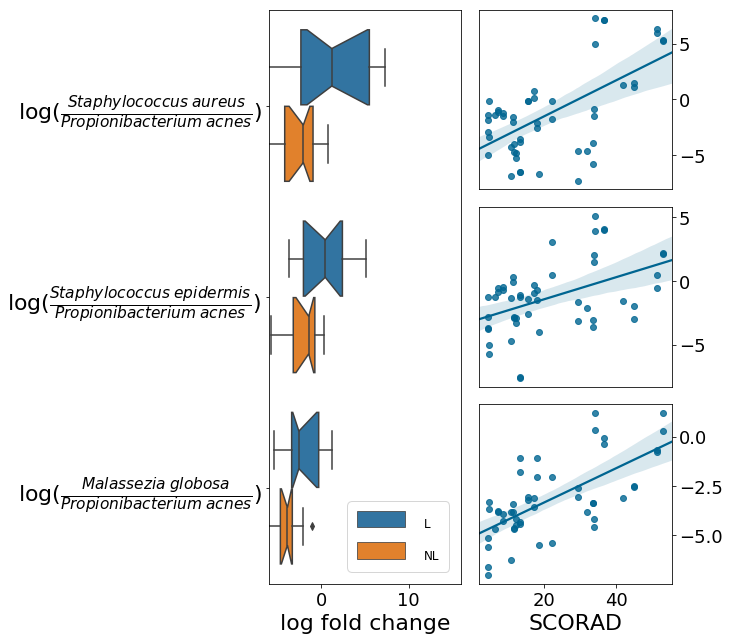

In [21]:
fig = plt.figure(figsize=(10, 9))
gs = gridspec.GridSpec(3, 2)
ax = fig.add_subplot(gs[:, 0])

g = sns.factorplot(x='value', y='balance', data=df, hue='Timepoint', kind='box',
                   hue_order=['F', 'PF'], ax=ax, notch=True, bootstrap=10000)
_ = ax.set_ylabel('')
ax.set_xlim([-6, 16])
L = ax.legend(loc=4, fontsize=24)
L.get_texts()[0].set_text('L')
L.get_texts()[1].set_text('NL')

ax.set_yticklabels([
    r'$\log (\frac{Staphylococcus \; aureus}{Propionibacterium \; acnes})$',
    r'$\log (\frac{Staphylococcus \; epidermis}{Propionibacterium \; acnes})$',
    r'$\log (\frac{Malassezia \; globosa}{Propionibacterium \; acnes})$'
], fontsize=22, rotation=0)
ax.set_xlabel('log fold change', fontsize=22)
ax.xaxis.set_tick_params(labelsize=18)
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title

ax1 = fig.add_subplot(gs[0, 1])
plot_scatter('log(S.aureus/P.acnes)', data, ax1, ylabel='')

ax2 = fig.add_subplot(gs[1, 1])
plot_scatter('log(S.epidermis/P.acnes)', data, ax2, ylabel='')

ax3 = fig.add_subplot(gs[2, 1])
plot_scatter('log(M.globosa/P.acnes)', data, ax3, ylabel='', keep_xaxis=True)
ax3.set_xlabel('SCORAD', fontsize=22)

plt.close(g.fig)
plt.tight_layout()
fig.savefig('../figures/figure3/byrd-post-flare-balances.png')

staphylococcus epidermis, 
staphylococcus aureus,
malasseziaceae globosa,
propionibacterium

In [22]:
data = pd.merge(table[[s_aureus, s_epidermis, m_globosa, p_acnes]], 
                metadata, left_index=True, right_index=True)
subdata = data.loc[data.Timepoint != 'B']
subdata = subdata[[s_aureus, s_epidermis, m_globosa, p_acnes, 'Timepoint']]
df = pd.melt(subdata, id_vars='Timepoint', var_name='abundance')

/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


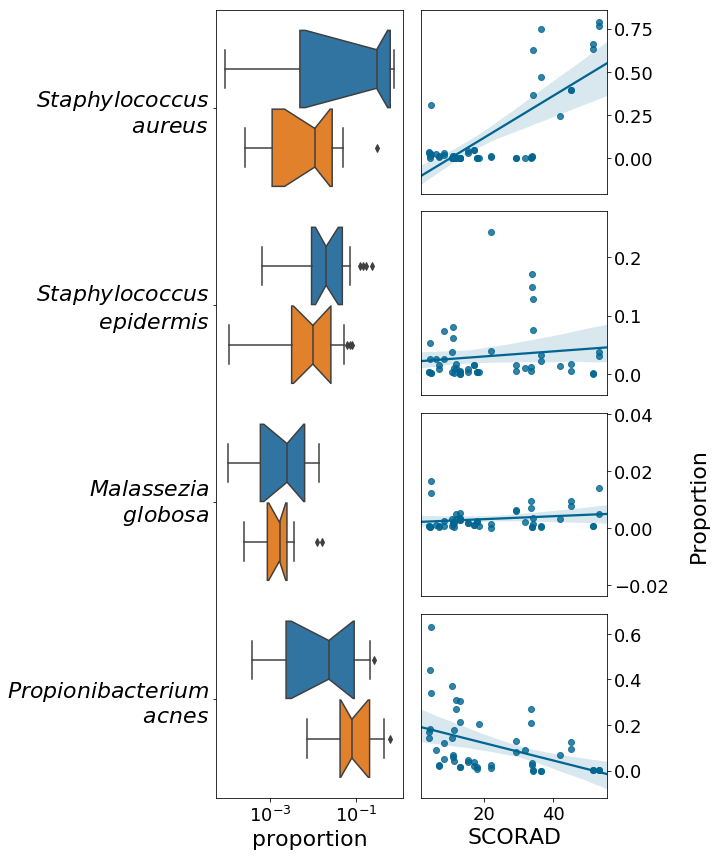

In [23]:
fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(4, 2)
ax = fig.add_subplot(gs[:, 0])

g = sns.factorplot(x='value', y='abundance', data=df, hue='Timepoint', kind='box',
              hue_order=['F', 'PF'], ax=ax, notch=True, bootstrap=100000)
_ = ax.set_ylabel('')
ax.legend_.remove()

ax.set_yticklabels([
    '$\it{Staphylococcus}$\n $\it{aureus}$',
    '$\it{Staphylococcus}$\n $\it{epidermis}$',
    '$\it{Malassezia}$\n $\it{globosa}$',    
    '$\it{Propionibacterium}$\n $\it{acnes}$'
], fontsize=22, rotation=0)
ax.set_xscale('log')
ax.set_xlabel('proportion', fontsize=22)
ax.xaxis.set_tick_params(labelsize=18)

ax1 = fig.add_subplot(gs[0, 1])
plot_scatter(s_aureus, data, ax1, ylabel='')

ax2 = fig.add_subplot(gs[1, 1])
plot_scatter(s_epidermis, data, ax2, ylabel='')

ax3 = fig.add_subplot(gs[2, 1])
plot_scatter(m_globosa, data, ax3, ylabel='Proportion')

ax4 = fig.add_subplot(gs[3, 1])
plot_scatter(p_acnes, data, ax4, ylabel='', keep_xaxis=True)
ax4.set_xlabel('SCORAD', fontsize=22)

plt.close(g.fig)
plt.tight_layout()
fig.savefig('../figures/figure3/byrd-post-flare-proportions.png')

Plot the results from Livias experiment

In [24]:
#data = pd.read_excel('../data/Livia-food-allergy-AD-data.xlsx', 
#                     sheet_name='reorganized', index_col=0)

#data2 = pd.read_excel('../data/df_meta_Species_nov2018_62participants_relativeANDcounts.xlsx', 
#                     sheet_name='relative_abundance_counts')
#data2 = pd.read_excel('../data/df_meta_Species_nov2018_62participants_relativeANDcounts.xlsx', 
#                     sheet_name='malassezia')

data = pd.read_table('../data/read_counts_BacteriaMalassezia_62subjectsUPto3mismatchs_ADonly.txt')

In [25]:
table = data[['Samples', 'Taxa', 'Counts']].pivot(index='Samples', columns='Taxa', values='Counts')
metadata = data[['Samples', 'Condition', 'Group']].drop_duplicates()

table = table.fillna(0)
table = table.iloc[:, 1:]
total = table.apply(lambda x: x.sum(), axis=1)

In [26]:
metadata = metadata.set_index('Samples')
table = table[['Malassezia globosa', 'Propionibacterium acnes']]
table['log-ratio'] = table.apply(lambda x: np.log(x['Malassezia globosa'] / x['Propionibacterium acnes']), axis=1)

/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
table = table.rename(
    columns={'Malassezia globosa': 'M. globosa', 
             'Propionibacterium acnes': 'P. acnes'}
)
table['%M.glo'] = table['M. globosa'] / total
data = pd.merge(table, metadata, left_index=True, right_index=True)

In [28]:
# This is for Livia's new data
#data = data.loc[data.Taxa == 'Propionibacterium acnes']
#data['subject'] = data.Samples.apply(lambda x: x.split('-')[2])
#data = data[['Samples', 'Counts', 'Condition', 'subject']]
#data = data.rename(columns={'Counts': 'P. acnes'})

#data2 = data2.loc[data2.Taxa=='Malassezia globosa']
#data2['subject'] = data2.Samples.apply(lambda x: x.split('-')[2])
#data2 = data2[['Samples', 'Counts']]
#data2 = data2.rename(columns={'Counts': 'M. globosa '})
#data = pd.merge(data, data2, left_on='Samples', right_on='Samples')

In [29]:
subset = data[['M. globosa', 'P. acnes', '%M.glo', 'Condition']].dropna()
subset['log-ratio'] = np.log(subset['M. globosa'] / subset['P. acnes'])
subset['subject'] = list(map(lambda x: x.split('-')[2], subset.index))

In [30]:
l = subset.loc[subset['Condition'] == 'lesion', 'log-ratio']
nl = subset.loc[subset['Condition'] == 'nonlesion', 'log-ratio']

In [31]:
s1 = set(subset.loc[subset['Condition'] == 'lesion'].subject.unique())
s2 = set(subset.loc[subset['Condition'] == 'nonlesion'].subject.unique())
common_subjects = s1 & s2
idx = subset.subject.apply(lambda x: x in common_subjects)
subset = subset.loc[idx]

In [32]:
ldiffs = subset.groupby('subject').diff(periods=-1).dropna()

/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


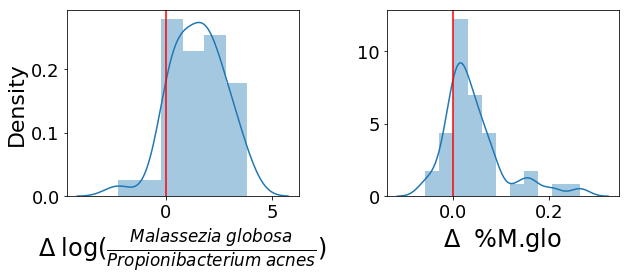

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.distplot(ldiffs['log-ratio'], ax=ax[0])
sns.distplot(ldiffs['%M.glo'], ax=ax[1])
ax[0].set_ylabel('Density', fontsize=22)
ax[0].set_xlabel(
    r'$\Delta \; \log (\frac{Malassezia \; globosa}{Propionibacterium \; acnes})$',
    fontsize=24)
ax[0].xaxis.set_tick_params(labelsize=18)
ax[0].yaxis.set_tick_params(labelsize=18)

ax[1].set_xlabel(r'$\Delta \;$ %M.glo', 
                 fontsize=24)
ax[1].xaxis.set_tick_params(labelsize=18)
ax[1].yaxis.set_tick_params(labelsize=18)

ax[0].axvline(x=0, c='r')
ax[1].axvline(x=0, c='r')
#plt.suptitle('Allergy Cohort Lesion-Nonlesion differences', fontsize=24)
plt.tight_layout()
fig.savefig('../figures/figure3/livia-lr-proportions.png')

Let's see how that statistical tests here look

In [34]:
ttest_rel(
    subset.loc[subset.Condition=='lesion', 'log-ratio'].values,
    subset.loc[subset.Condition=='nonlesion', 'log-ratio'].values
 )

Ttest_relResult(statistic=7.298794084366947, pvalue=9.729855826195894e-09)

In [35]:
ttest_rel(
    subset.loc[subset.Condition=='lesion', '%M.glo'].values,
    subset.loc[subset.Condition=='nonlesion', '%M.glo'].values
 )

Ttest_relResult(statistic=4.1349152698631695, pvalue=0.00018884689177052285)